### Read the input data

In [198]:
gdf = gpd.GeoDataFrame.from_file("sample_0.geojson").set_crs(4326)
gdf

,geometry
0,"POLYGON ((11.13284 46.05772, 11.13876 46.05772..."
1,"POLYGON ((11.12417 46.09228, 11.17104 46.09228..."
2,POINT (11.12434 46.05918)
3,POINT (11.13276 46.07204)
4,"POLYGON ((11.15696 46.05667, 11.15490 46.05298..."


### Visualize input data

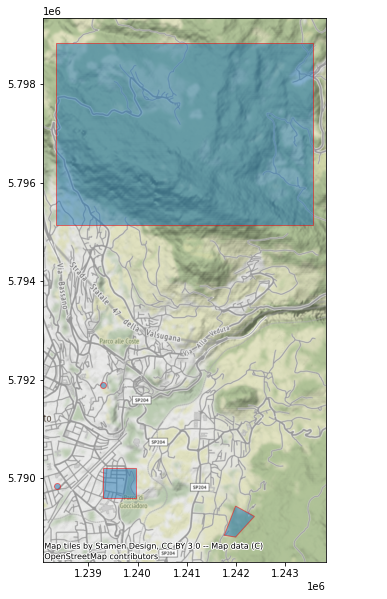

In [4]:
# Source https://geopandas.org/en/stable/gallery/plotting_basemap_background.html
df_wm = gdf.to_crs(epsg=3857)

ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='r')
cx.add_basemap(ax)

### Divide features into polygons and points (TODO: add handling of MultiPolygons)

In [114]:
points_gdf   = gpd.GeoDataFrame(columns=gdf.columns).set_crs(4326)
polygons_gdf = gpd.GeoDataFrame(columns=gdf.columns).set_crs(4326)

In [115]:
for idx, row in gdf.iterrows():
    if type(row.geometry) == Polygon:
        polygons_gdf = polygons_gdf.append(row,ignore_index=True)
    if type(row.geometry) == Point:
        points_gdf = points_gdf.append(row,ignore_index=True)

In [116]:
polygons_gdf = polygons_gdf.set_crs(4326)
polygons_gdf

,geometry
0,"POLYGON ((11.13284 46.05772, 11.13876 46.05772..."
1,"POLYGON ((11.12417 46.09228, 11.17104 46.09228..."
2,"POLYGON ((11.15696 46.05667, 11.15490 46.05298..."


In [117]:
points_gdf = points_gdf.set_crs(4326)
points_gdf

,geometry
0,POINT (11.12434 46.05918)
1,POINT (11.13276 46.07204)


### Random sampling

In [129]:
## parameters
sampling = 'random'
# cellSize = 0.01 # spatial resolution of the requested points. Min distance between them
# One or the other must be provided
max_count_geometry = 10 # or number or size: number of requested points each geometry, it can be None (infinite)
max_count_total    = None

In [130]:
## Compute the total area of all the polygons
## We tranform first the points to an equal area projection
## Found this CRS in this discussion, can be changed https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas
polygons_gdf_6933 = polygons_gdf.to_crs(6933)
                                        
gdf_areas = np.asarray([geom.area for geom in polygons_gdf_6933['geometry']])
tot_area = np.sum(gdf_areas)
tot_area

9534276.100124845

In [146]:
# Depending on the max number of points we want to extract and the area of each polygon,
# we extract a proportional number of points for each polygon depending on its area
# Minimum number of points extracted from each geometry is 1.

# Check if the max number of points is greater than the number of geometries
features_count = len(points_gdf) + len(polygons_gdf)
if max_count_total is not None:
    if max_count_total < features_count:
        raise Exception("The maximum number of points must be >= the number of features of the provided geoJSON!\
     max_count_total = {} numb of features = {}".format(max_count_total,features_count))
    
    # Compute how many points per area unit we will sample
    # We need to subtract the number of points provided as input first

    pts_per_unit = (max_count_total - len(points_gdf)) / tot_area
    pts_each_polygon = np.multiply(pts_per_unit,gdf_areas)
    # Round the number of points to the closest integer
    pts_each_polygon = np.floor(pts_each_polygon).astype(int) # or np.round
    # Check if there are polygons which will have a single point
    pts_each_polygon[pts_each_polygon==0] = 1
else:
    pts_each_polygon = np.asarray([max_count_geometry for i in range(len(polygons_gdf_6933['geometry']))])

In [132]:
pts_each_polygon

array([10, 10, 10])

In [133]:
# Check if the computed number of samples each polygon are greater than the requested number for each polygon

In [134]:
if max_count_geometry is not None and max_count_geometry>0:
    pts_each_polygon = [p if p<=max_count_geometry else max_count_geometry for p in pts_each_polygon]

In [135]:
pts_each_polygon

[10, 10, 10]

In [136]:
# Loop over all the polygons:
for idx, polygon in polygons_gdf.iterrows():
    # find area bounds
    bounds = polygon.geometry.bounds
    xmin, ymin, xmax, ymax = bounds

    xext = xmax - xmin
    yext = ymax - ymin
    
    count = 0
    while count < pts_each_polygon[idx]:
        # generate a random x and y
        x = xmin + random.random() * xext
        y = ymin + random.random() * yext
        p = Point(x, y)
        if polygon.geometry.contains(p):  # check if point is inside geometry
            point = polygon.copy()
            point.geometry = p
            points_gdf = points_gdf.append(point,ignore_index=True)
            count += 1


### Visualize the result

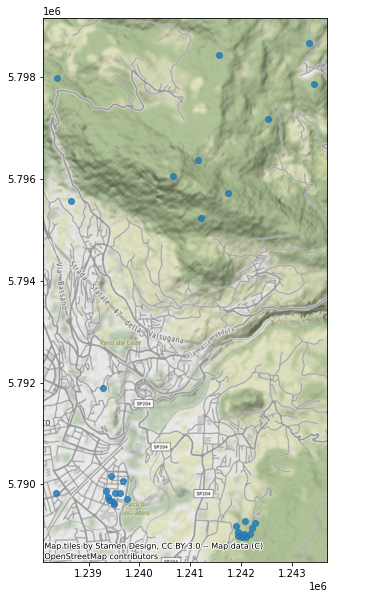

In [137]:
df_wm = points_gdf.set_crs(4326).to_crs(epsg=3857)

ax = df_wm.plot(figsize=(10, 10), alpha=0.8)
cx.add_basemap(ax)

### Write to file

In [13]:
points_gdf.to_file("urban_forest_points.geojson", driver="GeoJSON")

### Regular grid sampling

In [189]:
points_gdf   = gpd.GeoDataFrame(columns=gdf.columns).set_crs(4326)
polygons_gdf = gpd.GeoDataFrame(columns=gdf.columns).set_crs(4326)

In [190]:
for idx, row in gdf.iterrows():
    if type(row.geometry) == Polygon:
        polygons_gdf = polygons_gdf.append(row,ignore_index=True)
    if type(row.geometry) == Point:
        points_gdf = points_gdf.append(row,ignore_index=True)

In [191]:
polygons_gdf = polygons_gdf.set_crs(4326)
polygons_gdf

,geometry
0,"POLYGON ((11.13284 46.05772, 11.13876 46.05772..."
1,"POLYGON ((11.12417 46.09228, 11.17104 46.09228..."
2,"POLYGON ((11.15696 46.05667, 11.15490 46.05298..."


In [192]:
points_gdf = points_gdf.set_crs(4326)
points_gdf

,geometry
0,POINT (11.12434 46.05918)
1,POINT (11.13276 46.07204)


In [193]:
## parameters
sampling = 'regular'
cell_size = 0.0017 # spatial resolution of the requested points. Min distance between them

In [194]:
# Loop over all the polygons:
for idx, polygon in polygons_gdf.iterrows():
    # find area bounds
    bounds = polygon.geometry.bounds
    xmin, ymin, xmax, ymax = bounds
    
    xx, yy = np.meshgrid(np.linspace(xmin,xmax,int((xmax-xmin)/cell_size)), np.linspace(ymin,ymax,int((ymax-ymin)/cell_size)))
    xc = xx.flatten()
    yc = yy.flatten()
    
    # Now convert these points to geo-data
    pts = gpd.GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
    in_map =  np.array([pts.within(polygon.geometry)]).sum(axis=0)
    pts = [val for pos,val in enumerate(pts) if in_map[pos]]
    
    print(len(pts))
    
    for pt in pts:
        point = polygon.copy()
        point.geometry = pt
        points_gdf = points_gdf.append(point,ignore_index=True)
    # count = 0
    # while count < pts_each_polygon[idx]:
    #     # generate a random x and y
    #     x = xmin + random.random() * xext
    #     y = ymin + random.random() * yext
    #     p = Point(x, y)
    #     if polygon.geometry.contains(p):  # check if point is inside geometry
    #         point = polygon.copy()
    #         point.geometry = p
    #         points_gdf = points_gdf.append(point,ignore_index=True)
    #         count += 1


0
275
0


In [195]:
points_gdf

,geometry
0,POINT (11.12434 46.05918)
1,POINT (11.13276 46.07204)
2,POINT (11.12597 46.09420)
3,POINT (11.12778 46.09420)
4,POINT (11.12958 46.09420)
...,...
272,POINT (11.16202 46.11334)
273,POINT (11.16383 46.11334)
274,POINT (11.16563 46.11334)
275,POINT (11.16743 46.11334)


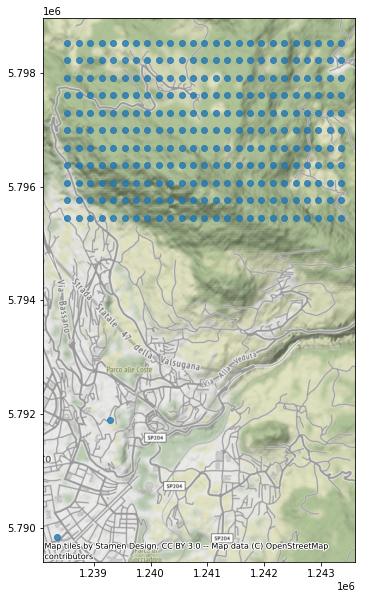

In [196]:
df_wm = points_gdf.set_crs(4326).to_crs(epsg=3857)

ax = df_wm.plot(figsize=(10, 10), alpha=0.8)
cx.add_basemap(ax)